## Load Csv Data

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

## In memory data
For any small CSV dataset, the simplest way to train a tensorflow model on it is to load it into memory as pandas dataframe or numpy array

In [2]:
abalone_train = pd.read_csv(
                            "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
                            names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
                            "Viscera weight", "Shell weight", "Age"])

In [3]:
abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


The dataset contains a set of measurements of abalone, a type of sea snail.

The nominal task for this dataset is to predict the age from the other measurements, so separate the features and labels for training:

In [4]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')

In [5]:
# We will treat all features identically so we pack the features into a single numpy array
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435 , 0.335 , 0.11  , ..., 0.1355, 0.0775, 0.0965],
       [0.585 , 0.45  , 0.125 , ..., 0.3545, 0.2075, 0.225 ],
       [0.655 , 0.51  , 0.16  , ..., 0.396 , 0.2825, 0.37  ],
       ...,
       [0.53  , 0.42  , 0.13  , ..., 0.3745, 0.167 , 0.249 ],
       [0.395 , 0.315 , 0.105 , ..., 0.1185, 0.091 , 0.1195],
       [0.45  , 0.355 , 0.12  , ..., 0.1145, 0.0665, 0.16  ]])

Now, We make a Regression Model to predict the age. Since there is only a single input tensor, a Sequential Model will do just fine here

In [6]:
abalone_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [7]:
abalone_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
abalone_model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# abalone_model.fit(abalone_features, abalone_labels, epochs=10)

You have just seen the most basic way to train a model using CSV data. Next, you will learn how to apply preprocessing to normalize numeric columns

## Basic Preprocessing

As Always, The Best Practise is to Normalize the inputs

In [10]:
normalize = layers.Normalization()

In [11]:
normalize.adapt(abalone_features)

Then, Use the Normalization layer in your model

In [12]:
norm_abalone_model = tf.keras.Sequential([
    normalize,
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [13]:
norm_abalone_model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

## Mixed Data Types

In the previous sections, you worked with a dataset where all the features were limited-range floating point values. But not all datasets are limited to a single data type.

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived.

The raw data can easily be loaded as a Pandas DataFrame, but is not immediately usable as input to a TensorFlow model.

In [15]:
titanic = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

In [16]:
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [17]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

You must have noticed by now that because of the different ranges and data types, the features can't be simply stacked into a numpy array and passed to Sequential Model. Each column needs to be handled individually.

The Functional API operates on symbolic tensors. Normal Eager tensors have a value whereas symbolic tensors do not. Instead they keep track of which operations are run on them, and build a representation of the calculation, that you can ran later. As shown in the example

In [18]:
# Create a Symbolic Input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

result # has no value

<KerasTensor shape=(None,), dtype=float32, sparse=False, name=keras_tensor_2>

In [19]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [20]:
print(calc(np.array([1])).numpy())
print(calc(np.array([2])).numpy())
print(calc(np.array([4])).numpy())

[3.]
[5.]
[9.]


To Build the preprocessing model, start by building a set of symbolic `tf.keras.Input` objects matching the names and data types of the CSV columns

In [21]:
inputs = {}

for name, column in titanic_features.items():
    dtype = column.dtype
    print(dtype)
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

object
float64
int64
int64
float64
object
object
object
object


In [22]:
inputs

{'sex': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=sex>,
 'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>,
 'n_siblings_spouses': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=n_siblings_spouses>,
 'parch': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=parch>,
 'fare': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=fare>,
 'class': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=class>,
 'deck': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=deck>,
 'embark_town': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=embark_town>,
 'alone': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=alone>}

The First step in the preprocessing logic is to concatenate the numeric inputs together, and run them thorugh a normalization layer

In [23]:
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = x

all_numeric_inputs

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_3>

Collect all the symbolic preprocessing results, to concatenate them later

In [24]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `tf.keras.layers.StringLookup` function to map from strings to integer indices in a vocabulary, Next use `layers.CategoryEncoding` to convert the indexes into float32 data appropriate for the model.

In [25]:
for name, inputType in inputs.items():
    print(name, inputType)
    if inputType == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(inputType)
    x = one_hot(x)

    preprocessed_inputs.append(x)

sex <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=sex>
age <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>
n_siblings_spouses <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=n_siblings_spouses>
parch <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=parch>
fare <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=fare>
class <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=class>
deck <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=deck>
embark_town <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=embark_town>
alone <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=alone>


With the collection of `inputs` and `preprocessed_inputs`, we can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing

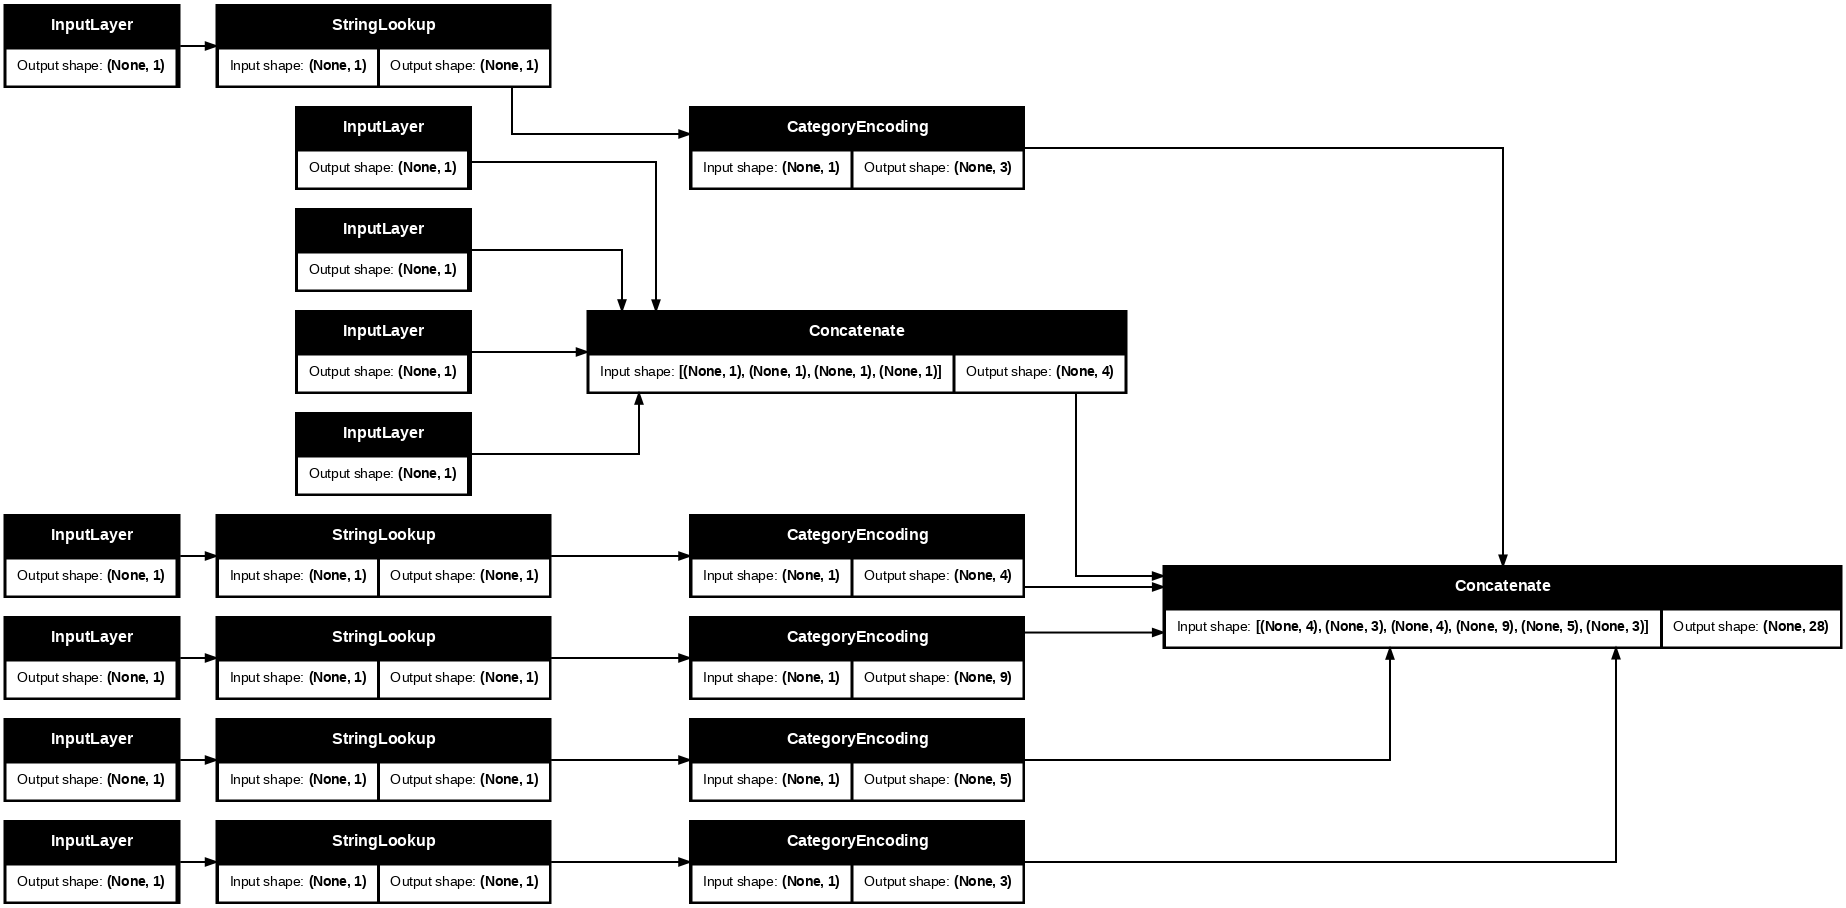

In [26]:
preprocessed_inputs_concatenated = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_concatenated)

tf.keras.utils.plot_model(model=titanic_preprocessing, rankdir='LR', dpi=72, show_shapes=True)

This image shows a preprocessing model architecture for handling what appears to be tabular data with both numerical and categorical features. Here's a breakdown of what I understand from it:

1. Input Data:

- The model is designed to process tabular data with multiple columns (features). Each "InputLayer" represents a single column from your dataset.
- The presence of "StringLookup" indicates that some of these columns contain categorical data in string format (e.g., "red", "blue", "green").
- Other columns likely contain numerical data, as they are fed directly to the "Concatenate" layer.

2. Preprocessing Steps:
- String Lookup: "StringLookup" layers are used to convert string categories into numerical indices. This is a necessary step before feeding categorical data into a machine learning model.
- Category Encoding: "CategoryEncoding" layers likely perform one-hot encoding on the indexed categorical data. This transforms each categorical feature into a binary vector, where each position represents a possible category. This helps the model learn relationships between categories more effectively.
- Concatenation: After the categorical features are encoded, they are concatenated with the numerical features using the "Concatenate" layer. This combines all the processed features into a single input vector for the subsequent machine learning model.

3. Overall Structure:
- The architecture suggests a modular approach to preprocessing. Each column goes through its own preprocessing pipeline (StringLookup -> CategoryEncoding) before being combined.
- The repeated structure implies that you have multiple groups of features with similar preprocessing needs.


4. Purpose:
- The primary goal of this preprocessing model is to transform raw tabular data into a suitable format for training a machine learning model. This involves:
- Converting categorical data into a numerical representation.
- Potentially handling missing values (though not explicitly shown in the diagram).
- Combining all features into a single input vector.

This model just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert pandas DataFrames because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So, convert it to a dictionary of tensors

In [27]:
# for name, value in titanic_features.items():
#     print(name, np.array(value))

In [28]:
titanic_features_dict = {name: np.array(value) for name, value in titanic_features.items()}

Slice out the first example and pass it to this preprocessing model, we see the numeric features and strings one-hots all concatenated together

In [29]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
features_dict

{'sex': array(['male'], dtype=object),
 'age': array([22.]),
 'n_siblings_spouses': array([1]),
 'parch': array([0]),
 'fare': array([7.25]),
 'class': array(['Third'], dtype=object),
 'deck': array(['unknown'], dtype=object),
 'embark_town': array(['Southampton'], dtype=object),
 'alone': array(['n'], dtype=object)}

In [30]:
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[22.  ,  1.  ,  0.  ,  7.25,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,
         0.  ]], dtype=float32)>

Now, We will build the model on top of this

In [31]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)

    model = tf.keras.Model(inputs, result)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam')

    return model

In [32]:
titanic_model = titanic_model(titanic_preprocessing, inputs)

In [33]:
# titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

## Multiple Files

The `character font images` dataset is distributed as a collection of csv files, one per font. We will start by downloading the dataset

In [34]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip', "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.',
    cache_subdir='fonts',
    extract=True
)

159850496/Unknown 6s 0us/step

In [35]:
import pathlib

In [111]:
font_csvs = sorted(str(p) for p in pathlib.Path('fonts/').glob('*csv'))

In [112]:
font_csvs[:10]

['fonts/AGENCY.csv',
 'fonts/ARIAL.csv',
 'fonts/BAITI.csv',
 'fonts/BANKGOTHIC.csv',
 'fonts/BASKERVILLE.csv',
 'fonts/BAUHAUS.csv',
 'fonts/BELL.csv',
 'fonts/BERLIN.csv',
 'fonts/BERNARD.csv',
 'fonts/BITSTREAMVERA.csv']

In [38]:
len(font_csvs)

0

When dealing with a bunch of files, you can pass a glob-style `file_pattern` to the `tf.data.experimental.make_csv_dataset` function. The order of the files is shuffled each iteration.

Use the `num_parrallel_reads` arg to set how many files are read in parallel

In [40]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = 'fonts/*.csv',
    batch_size=10,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000
)

These CSV files have the images flattened out into a single row. The column names are formatted r{row}c{column}

In [41]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'BUXTON' b'LEELAWADEE' b'PALACE' b'NUMERICS' b'MODERN' b'LEELAWADEE'
 b'PRISTINA' b'ELEPHANT' b'ELEPHANT' b'PALACE']
fontVariant         : [b'BUXTON SKETCH' b'LEELAWADEE UI SEMILIGHT' b'PALACE SCRIPT MT'
 b'scanned' b'MODERN NO. 20' b'LEELAWADEE UI SEMILIGHT' b'PRISTINA'
 b'ELEPHANT' b'ELEPHANT' b'PALACE SCRIPT MT']
m_label             : [ 122 6041  208   49 8218 6016 8730  196 8250   82]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [0 0 1 0 1 0 1 1 1 1]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [48 47 29  0 68 47 36 23 58 29]
m_left              : [20 27 21  0 19 25 27 18 19 21]
originalH           : [31 37 37 16 13 37 43 64 24 37]
originalW           : [30 57 52  8 11 46 43 74 20 56]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [ 31 207   1   0   1   1   1   1   1   1]
r0c1                : [201 255   1

### Packing Fields

If I would have to guess, I feel no one wants to work with each pixel in seperate columns like this. before trying to use this dataset, be sure to pack the pixels into an image tensor

Now, We write a function that parses the column names to build images for each example

In [80]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

In [81]:
# Apply the make_images function to each batch in the dataset
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 10608 (\N{RIGHT DOUBLE ARROW WITH ROUNDED HEAD}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10608 (\N{RIGHT DOUBLE ARROW WITH ROUNDED HEAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


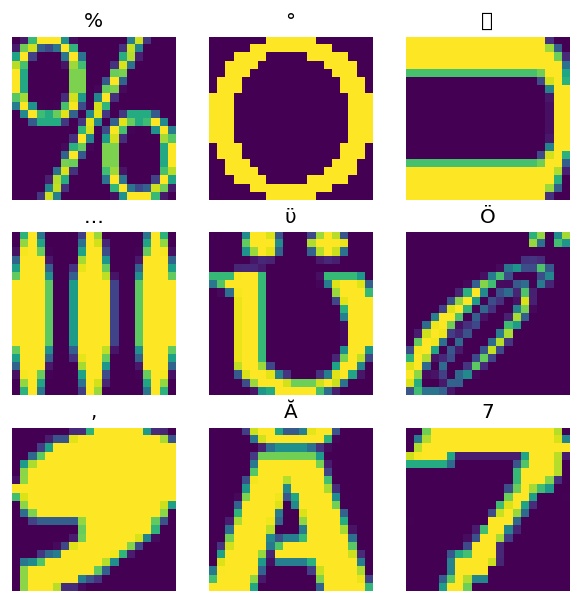

In [82]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')

## Lower Level Functions

There are two other APIs that can be helpful in advanced use-cases
- `tf.io.decode_csv`: a function for parsinf lines pof text into a list of CSV column tensors.
- `tf.data.experimental.CsvDatasheet`: a lower-level CSV dataset constructor.


### tf.io.decode_csv

This function decodes a string, or list of strings into a list of columns. Unlike `make_csv_datasheet`, this function does not try to guess column data-types. You specify the column types by providing a list of  `record_defaults` containing a value fo the correct type, for each column.

To read the Titanic data as strings using `tf.io.decode_csv`, you would say

In [84]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

30874/30874 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [91]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
print(all_strings)

['', '', '', '', '', '', '', '', '', '']


In [93]:
features = tf.io.decode_csv(lines, record_defaults=all_strings)

In [98]:
for f in features:
  print(f"{f.dtype}, shape: {f.shape}")

<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)


To Parse them with their actual types, create a list of `record_defaults` of the corresponding types

In [99]:
print(lines[0])

0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [100]:
# We can now construct types seeing from the above results
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

[0, '', 0.0, 0, 0, 0.0, '', '', '', '']

In [101]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types)

In [102]:
for f in features:
  print(f"{f.dtype}, shape: {f.shape}")

<dtype: 'int32'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'float32'>, shape: (627,)
<dtype: 'int32'>, shape: (627,)
<dtype: 'int32'>, shape: (627,)
<dtype: 'float32'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)
<dtype: 'string'>, shape: (627,)


## tf.data.experimental.CsvDataset
The `tf.data.experimental.CsvDataset` class provides a minimal CSV Dataset interface withourtthe convenience features of the `make_csv_Dataset` function. This constructor uses `record_defaults` the same way as the above Example.

In [103]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

In [104]:
for example in simple_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


### Multiple Files
To Parse the fonts dataset using `tf.data.experimental.CsvDatset`, you first need to determine the column types for the `record_defaults`. Start by inspecting the first row of one file

In [116]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[0]
font_line

'font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,r0c10,r0c11,r0c12,r0c13,r0c14,r0c15,r0c16,r0c17,r0c18,r0c19,r1c0,r1c1,r1c2,r1c3,r1c4,r1c5,r1c6,r1c7,r1c8,r1c9,r1c10,r1c11,r1c12,r1c13,r1c14,r1c15,r1c16,r1c17,r1c18,r1c19,r2c0,r2c1,r2c2,r2c3,r2c4,r2c5,r2c6,r2c7,r2c8,r2c9,r2c10,r2c11,r2c12,r2c13,r2c14,r2c15,r2c16,r2c17,r2c18,r2c19,r3c0,r3c1,r3c2,r3c3,r3c4,r3c5,r3c6,r3c7,r3c8,r3c9,r3c10,r3c11,r3c12,r3c13,r3c14,r3c15,r3c16,r3c17,r3c18,r3c19,r4c0,r4c1,r4c2,r4c3,r4c4,r4c5,r4c6,r4c7,r4c8,r4c9,r4c10,r4c11,r4c12,r4c13,r4c14,r4c15,r4c16,r4c17,r4c18,r4c19,r5c0,r5c1,r5c2,r5c3,r5c4,r5c5,r5c6,r5c7,r5c8,r5c9,r5c10,r5c11,r5c12,r5c13,r5c14,r5c15,r5c16,r5c17,r5c18,r5c19,r6c0,r6c1,r6c2,r6c3,r6c4,r6c5,r6c6,r6c7,r6c8,r6c9,r6c10,r6c11,r6c12,r6c13,r6c14,r6c15,r6c16,r6c17,r6c18,r6c19,r7c0,r7c1,r7c2,r7c3,r7c4,r7c5,r7c6,r7c7,r7c8,r7c9,r7c10,r7c11,r7c12,r7c13,r7c14,r7c15,r7c16,r7c17,r7c18,r7c19,r8c0,r8c1,r8c2,r8c3,r8c4,r8c5

Only the first two fields are strings, the rest are integers or floats, and you can get the total number of features by counting the commas

In [119]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()] * (num_font_features - 2)

In [121]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs,
    record_defaults=font_column_types,
    header=True
)